In [1]:
import os, sys
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt

import PulseTriggeringTools as ptt
import TimestreamHelperFunctions as Thf

In [2]:
def DrawGauss(ax, mu, sig, amp):
    xlim  = ax.get_xlim()
    xvals = np.linspace(xlim[0], xlim[1], 200)
#     yvals = (1./(np.sqrt(2.*np.pi)*sig)) * np.exp(-0.5*np.power((xvals-mu)/sig,2))
    yvals = amp * np.exp(-0.5*np.power((xvals-mu)/sig,2))
    ax.plot(xvals,yvals,'r')
    ax.set_xlim(xlim)

In [3]:
%matplotlib notebook

In [4]:
## Define the runs of interest
run_dict = {"series": [
    "20220721_123409",
    "20220721_123710",
    "20220721_124011",
    "20220720_150715",
    "20220720_150540",
    "20220720_144600",
    "20220720_150408",
    "20220720_150240",
    "20220720_150108",
    "20220720_145935",
    "20220720_144037" ] , 
            "Vled"  : [
    4.0,
    3.8,
    3.6,
    3.4,
    3.2,
    3.0,
    2.8,
    2.6,
    2.4,
    2.2,
    2.0 ] }
run_df = pd.DataFrame(run_dict)
run_df

,series,Vled
0,20220721_123409,4.0
1,20220721_123710,3.8
2,20220721_124011,3.6
3,20220720_150715,3.4
4,20220720_150540,3.2
5,20220720_144600,3.0
6,20220720_150408,2.8
7,20220720_150240,2.6
8,20220720_150108,2.4
9,20220720_145935,2.2


In [11]:
def AnalyzeSingleLED(Vled, verbose=False, show_plots=False):
    
    print(Vled)
    
    ## Share parameters between the two pulse findings
    _trigThr = 5.0e3
    _tauFall = 500e-6
    _meansps = 800
    _doalign = False
    
    ## Pull out the right series given the voltage
    series    = run_df['series'].loc[ np.round(run_df['Vled'],2)==Vled ].iloc[0]
    data_path = os.path.join('/data/USRP_Noise_Scans',series.split('_')[0],series)
    
    ## Find all the data files and show the user
    sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series, verbose=verbose)
    
    ## Phase response
    print("Phase...")
    pulseCount, traces = ptt.GetResponse(series, trig_channel="Phase", 
                                         traceLength=8192, trig_th=_trigThr, tauFall=_tauFall, 
                                         mean_pre_samps=_meansps, doAlign = False, 
                                         verbose=True, show_plots=show_plots)
    
    ##
    if pulseCount < 20:
        return -1, -1
    
    pulse_heights, taus = ptt.CalcPulseParams(traces)

    med_ph_phase  = np.median(pulse_heights)
    sig_ph_phase  = np.std(pulse_heights)
    med_tau_phase = np.median(taus)
    sig_tau_phase = np.std(taus)
    
    if show_plots:
        plt.figure()
        cts, bins, edges = plt.hist(pulse_heights)#,bins=height_bins)
        plt.xlabel('Phase Respone: Pulse Height [radians]')
        plt.title(r'$V_{\mathrm{LED}}=$ %.2f -- %s -- %i pulses' % (Vled, series, len(traces)))
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        plt.plot( med_ph_phase*np.ones(2) , ylim , 'r--')
        DrawGauss(plt.gca(), med_ph_phase, sig_ph_phase, np.max(cts))
        plt.gca().set_xlim(xlim)
        plt.gca().set_ylim(ylim)


        plt.figure()
        plt.xlabel(r'Phase Respone: $\tau$ [$\mu$s]')
        plt.title(r'$V_{\mathrm{LED}}=$ %.2f -- %s -- %i pulses' % (Vled, series, len(traces)))
        cts, bins, edges = plt.hist(taus,bins=25)
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        plt.plot( med_tau_phase*np.ones(2) , ylim , 'r--')
        DrawGauss(plt.gca(), med_tau_phase, sig_tau_phase, np.max(cts))
        plt.gca().set_xlim(xlim)
        plt.gca().set_ylim(ylim)
        
    ## Magnitude response
    print("Magnitude...")
    pulseCount, traces = ptt.GetResponse(series, trig_channel="Magnitude", 
                                         traceLength=4096, trig_th=_trigThr, tauFall=_tauFall, 
                                         mean_pre_samps=_meansps, doAlign = False, 
                                         verbose=True, show_plots=show_plots)
    
    ##
    if pulseCount < 20:
        return med_ph_phase, -1
    
    pulse_heights, taus = ptt.CalcPulseParams(traces)

    med_ph_mag  = np.median(pulse_heights)
    sig_ph_mag  = np.std(pulse_heights)
    med_tau_mag = np.median(taus)
    sig_tau_mag = np.std(taus)
    
    if show_plots:
        plt.figure()
        cts, bins, edges = plt.hist(pulse_heights)
        plt.xlabel('Magnitude Response: Pulse Height [radians]')
        plt.title(r'$V_{\mathrm{LED}}=$ %.2f -- %s -- %i pulses' % (Vled, series, len(traces)))
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        plt.plot( med_ph_mag*np.ones(2) , ylim , 'r--')
        DrawGauss(plt.gca(), med_ph_mag, sig_ph_mag, np.max(cts))
        plt.gca().set_xlim(xlim)
        plt.gca().set_ylim(ylim)

        plt.figure()
        plt.xlabel(r'Magnitude Respone: $\tau$ [$\mu$s]')
        plt.title(r'$V_{\mathrm{LED}}=$ %.2f -- %s -- %i pulses' % (Vled, series, len(traces)))
        cts, bins, edges = plt.hist(taus,bins=25)
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        plt.plot( med_tau_mag*np.ones(2) , ylim , 'r--')
        DrawGauss(plt.gca(), med_tau_mag, sig_tau_mag, np.max(cts))
        plt.gca().set_xlim(xlim)
        plt.gca().set_ylim(ylim)
        
    return med_ph_phase, med_ph_mag

In [12]:
Vleds     = run_df['Vled'].to_numpy()
magnt_phs = np.zeros(len(Vleds))
phase_phs = np.zeros(len(Vleds))
for i in np.arange(len(Vleds)):
    V = Vleds[i]
    
    phase_phs[i], magnt_phs[i] = AnalyzeSingleLED(V, show_plots=False)

4.0
Phase...
Line Delay file:  /data/USRP_Noise_Scans/20220721/20220721_123409/USRP_Delay_20220721_123409.h5
VNA scan file:    /data/USRP_Noise_Scans/20220721/20220721_123409/USRP_VNA_20220721_123409.h5
Timestream files: ['/data/USRP_Noise_Scans/20220721/20220721_123409/USRP_Noise_20220721_123409_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220721/20220721_123409/noise_averages_20220721_123409.h5
Pulse count: 760
Magnitude...
Line Delay file:  /data/USRP_Noise_Scans/20220721/20220721_123409/USRP_Delay_20220721_123409.h5
VNA scan file:    /data/USRP_Noise_Scans/20220721/20220721_123409/USRP_VNA_20220721_123409.h5
Timestream files: ['/data/USRP_Noise_Scans/20220721/20220721_123409/USRP_Noise_20220721_123409_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220721/20220721_123409/noise_averages_20220721_123409.h5
Pulse count: 883
3.8
Phase...
Line Delay file:  /data/USRP_Noise_Scans/20220721/20220721_123710/USRP_Delay_20220721_123710.h5
VNA scan file:    /data/USRP_Noise_Scans/20

Pulse count: 631
Magnitude...
Line Delay file:  /data/USRP_Noise_Scans/20220720/20220720_144037/USRP_Delay_20220720_144037.h5
VNA scan file:    /data/USRP_Noise_Scans/20220720/20220720_144037/USRP_VNA_20220720_144037.h5
Timestream files: ['/data/USRP_Noise_Scans/20220720/20220720_144037/USRP_Noise_20220720_144037_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220720/20220720_144037/noise_averages_20220720_144037.h5
Pulse count: 684


<IPython.core.display.Javascript object>


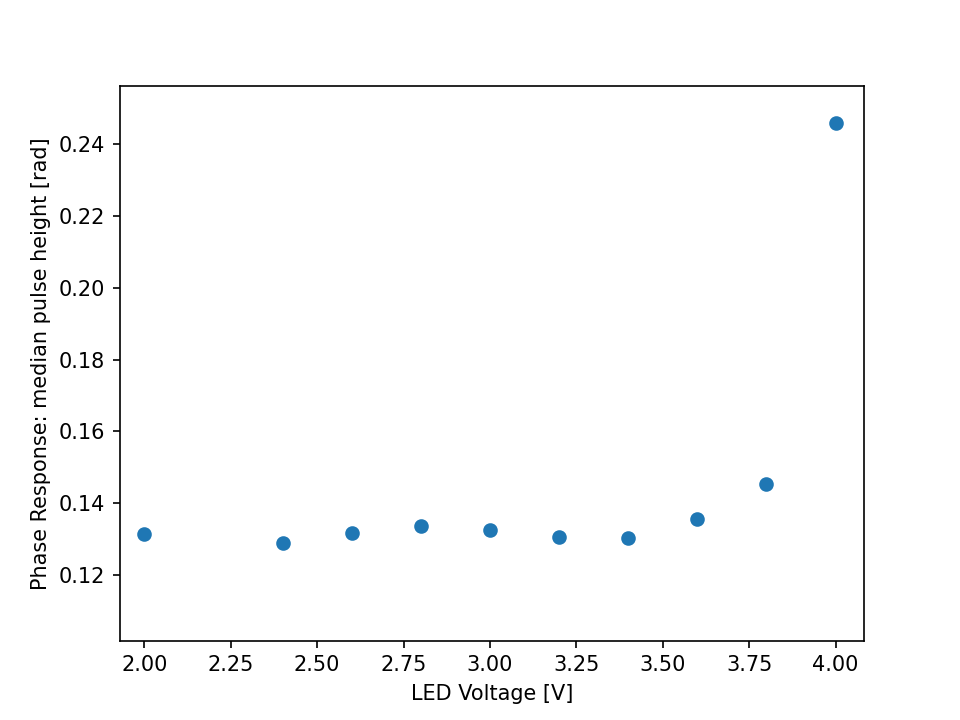

<IPython.core.display.Javascript object>


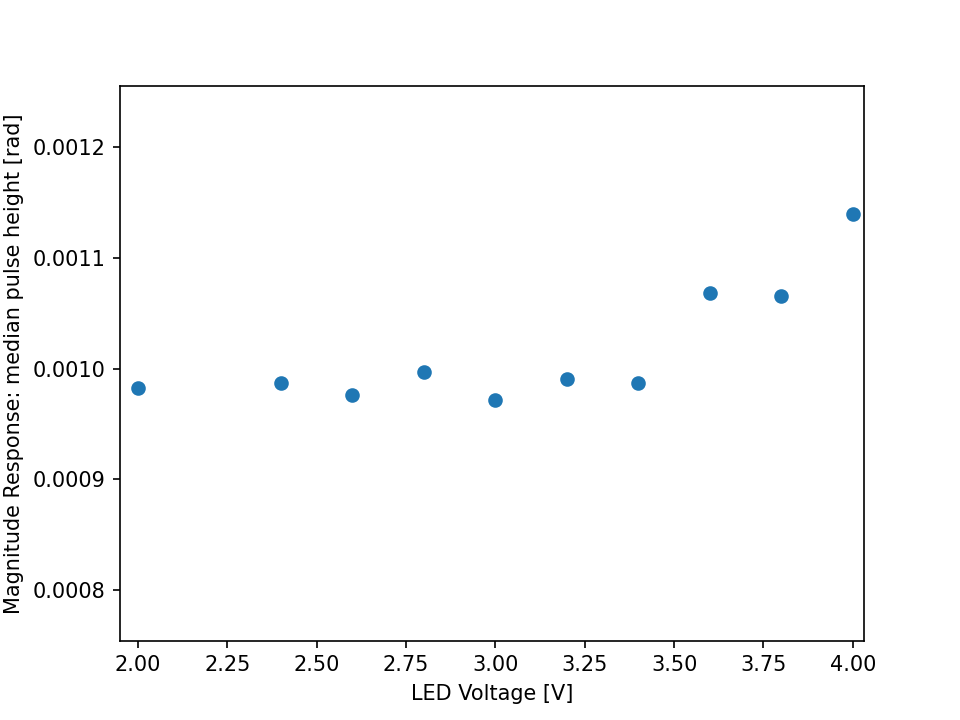

Text(0, 0.5, 'Magnitude Response: median pulse height [rad]')

In [13]:
plt.figure()
plt.scatter(Vleds, phase_phs)
plt.xlabel("LED Voltage [V]")
plt.ylabel("Phase Response: median pulse height [rad]")

plt.figure()
plt.scatter(Vleds, magnt_phs)
plt.xlabel("LED Voltage [V]")
plt.ylabel("Magnitude Response: median pulse height [rad]")